### Project Statement
This project is focused on building a Books Recommender System using "Collaborative filtering" that suggests books to users based on their interests. The system uses a machine learning model to find books that are similar to a given book based on user ratings. By analyzing how users rate different books, the system can recommend new books that a user might like.

The goal of the project is to create a system that processes book data, uses clustering techniques, and then provides book recommendations. This can help people discover new books that match their preferences, making it a helpful tool for book lovers or websites that want to offer personalized book suggestions.

### About the Dataset

https://www.kaggle.com/ra4u12/bookrecommendation
  
The dataset used in this project comes from Kaggle’s Book Recommendation Dataset and includes three main files:

#### Books Data (BX-Books.csv):
This file contains information about the books, including the title, author, publication year, publisher, and an image URL for the book cover. It has more than 271,000 book entries.

#### Users Data (BX-Users.csv):
This file includes details about the users, like user ID, location, and age. It helps us understand who is rating the books.

#### Ratings Data (BX-Book-Ratings.csv):
This file contains over a million ratings that users have given to books. Each record connects a user with a book (by its ISBN) and shows how they rated it.

In [ ]:
import os

# Suppress loky warning and avoid KMeans memory leak
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Set to the number of logical cores you want to use
os.environ['OMP_NUM_THREADS'] = '10'    # Limit the number of threads for KMeans

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import pickle

# Load the datasets with explicit dtype for columns
books = pd.read_csv('BX-Books.csv', sep=";", on_bad_lines='skip', encoding='latin-1', low_memory=False)
users = pd.read_csv('BX-Users.csv', sep=";", on_bad_lines='skip', encoding='latin-1')
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=";", on_bad_lines='skip', encoding='latin-1')

# Rest of your code...


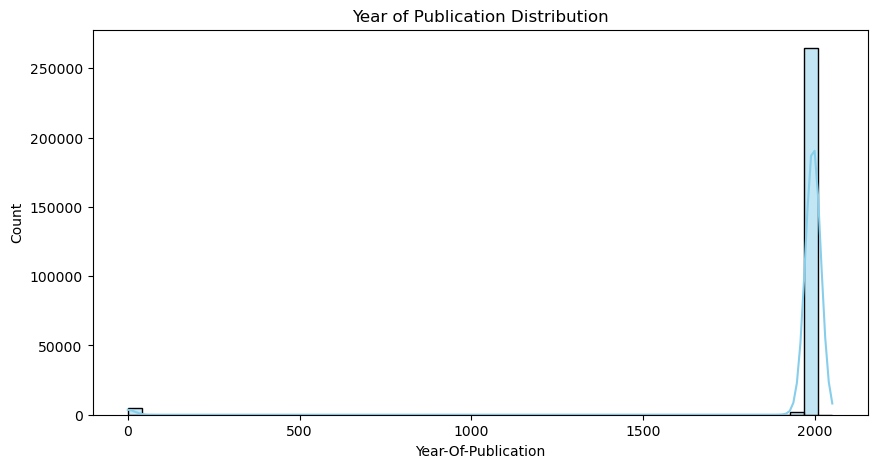

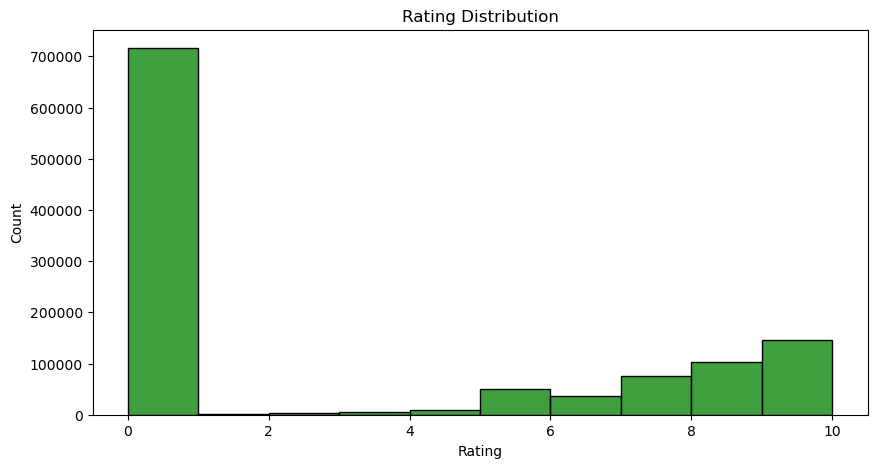

In [ ]:
# Clean and preprocess data without inplace=True
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
books['Year-Of-Publication'] = books['Year-Of-Publication'].fillna(books['Year-Of-Publication'].median())
users['Age'] = users['Age'].apply(lambda x: np.nan if x < 5 or x > 100 else x)
users['Age'] = users['Age'].fillna(users['Age'].median())

# Visualize book year distribution
plt.figure(figsize=(10, 5))
sns.histplot(books['Year-Of-Publication'], bins=50, kde=True, color='skyblue')
plt.title('Year of Publication Distribution')
plt.show()

# Visualize rating distribution
plt.figure(figsize=(10, 5))
sns.histplot(ratings['Book-Rating'], bins=10, kde=False, color='green')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()



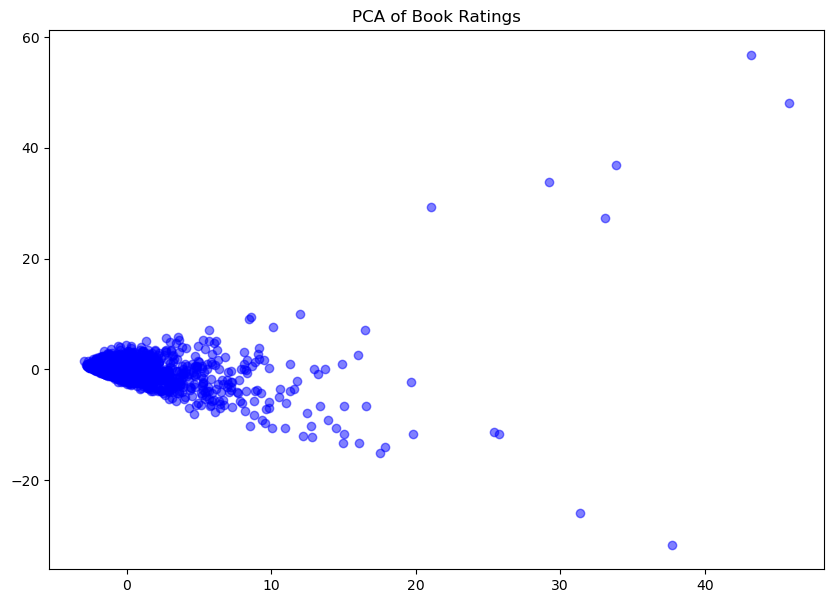

In [ ]:
# Merge ratings with books to get book titles
ratings_books = ratings.merge(books, on='ISBN')

# Filter active users
user_counts = ratings['User-ID'].value_counts()
active_users = user_counts[user_counts > 200].index
filtered_ratings = ratings[ratings['User-ID'].isin(active_users)]

# Filter popular books
book_counts = ratings_books['Book-Title'].value_counts()
popular_books = book_counts[book_counts >= 50].index

# Merge filtered ratings with books to get titles
final_ratings = filtered_ratings.merge(books, on='ISBN')
final_ratings = final_ratings[final_ratings['Book-Title'].isin(popular_books)]

# Create pivot table for clustering
book_pivot = final_ratings.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)

# Scale the data and apply PCA
scaler = StandardScaler()
book_pivot_scaled = scaler.fit_transform(book_pivot)
pca = PCA(n_components=2)
book_pca = pca.fit_transform(book_pivot_scaled)

# Visualize PCA
plt.figure(figsize=(10, 7))
plt.scatter(book_pca[:, 0], book_pca[:, 1], c='blue', alpha=0.5)
plt.title('PCA of Book Ratings')
plt.show()



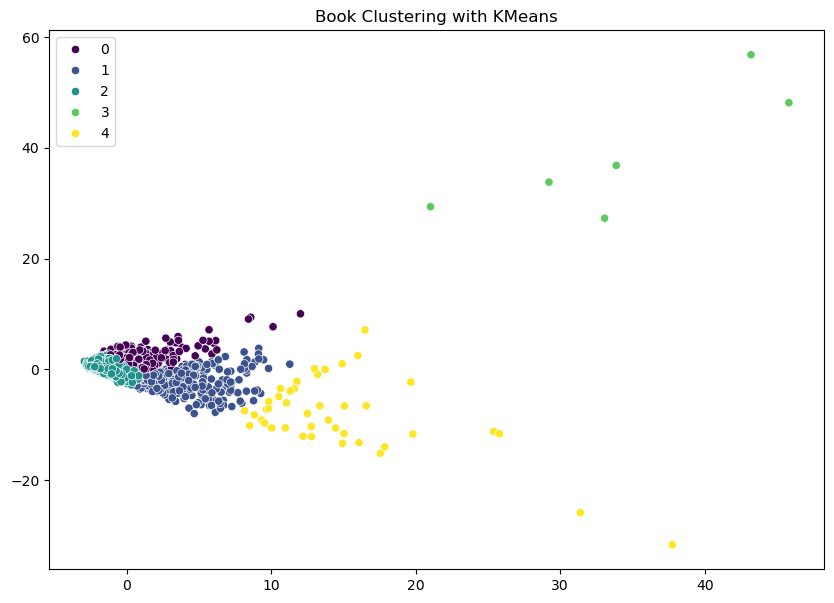

In [ ]:
# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(book_pca)

# Add cluster information
books_clustered = pd.DataFrame({'Book-Title': book_pivot.index, 'Cluster': clusters})
books = books.merge(books_clustered, on='Book-Title', how='left')

# Visualize clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=book_pca[:, 0], y=book_pca[:, 1], hue=clusters, palette='viridis')
plt.title('Book Clustering with KMeans')
plt.show()

# Save clustered books
books.to_csv('clustered_books.csv', index=False)



In [ ]:
# Train NearestNeighbors model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(book_pivot)

# Book recommendation function
def recommend_book(book_name="The Da Vinci Code"):
    if book_name not in book_pivot.index:
        print(f"'{book_name}' not found in the dataset.")
        return
    book_id = np.where(book_pivot.index == book_name)[0][0]
    distances, suggestions = model.kneighbors(book_pivot.iloc[book_id, :].values.reshape(1, -1), n_neighbors=6)

    print(f"Recommendations for '{book_name}':")
    for i in range(1, len(suggestions[0])):
        print(book_pivot.index[suggestions[0][i]])

# Example book recommendations
recommend_book("The Da Vinci Code")
recommend_book("Harry Potter and the Chamber of Secrets (Book 2)")

# Save model and data
pickle.dump(model, open('artifacts/model.pkl', 'wb'))
pickle.dump(book_pivot.index.tolist(), open('artifacts/book_names.pkl', 'wb'))

Recommendations for 'The Da Vinci Code':
Angels &amp; Demons
Doing Good
Touching Evil
TickTock
The Arraignment
Recommendations for 'Harry Potter and the Chamber of Secrets (Book 2)':
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Order of the Phoenix (Book 5)
